In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

resultsPath = Path("../results/MPI_7.csv")


In [26]:
dataFrame = pd.read_csv(resultsPath)
dataFrame["messageSizeBytes"] = dataFrame["messageSizeBytes"].astype(int)
dataFrame["numProcesses"] = dataFrame["numProcesses"].astype(int)
dataFrame["numIterations"] = dataFrame["numIterations"].astype(int)
dataFrame["computeUnits"] = dataFrame["computeUnits"].astype(int)
dataFrame["avgWallSeconds"] = dataFrame["avgWallSeconds"].astype(float)
dataFrame["avgCommSeconds"] = dataFrame["avgCommSeconds"].astype(float)
dataFrame["avgComputeSeconds"] = dataFrame["avgComputeSeconds"].astype(float)
dataFrame.head(6)

print("Rows:", len(dataFrame))
print("Modes:", dataFrame["mode"].unique())
print("Message sizes:", sorted(dataFrame["messageSizeBytes"].unique()))
print("Processes:", sorted(dataFrame["numProcesses"].unique()))
dataFrame.head(8)

Rows: 1200
Modes: ['blocking' 'nonblocking' 'comm_only' 'compute_only']
Message sizes: [1024, 16384, 65536, 262144, 1048576]
Processes: [1, 2, 4, 6, 8]


,testType,messageSizeBytes,numProcesses,mode,numIterations,computeUnits,avgWallSeconds,avgCommSeconds,avgComputeSeconds,runIndex,mpiEnv
0,MPI_7,1024,1,blocking,50,0,0.000010,0.000006,0.000001,1,PROCS=1
1,MPI_7,1024,1,blocking,50,0,0.000011,0.000008,0.000001,2,PROCS=1
2,MPI_7,1024,1,blocking,50,0,0.000010,0.000008,0.000001,3,PROCS=1
3,MPI_7,1024,1,nonblocking,50,0,0.000015,0.000004,0.000001,1,PROCS=1
4,MPI_7,1024,1,nonblocking,50,0,0.000022,0.000006,0.000001,2,PROCS=1
5,MPI_7,1024,1,nonblocking,50,0,0.000018,0.000005,0.000001,3,PROCS=1
6,MPI_7,1024,1,comm_only,50,0,0.000008,0.000006,0.000000,1,PROCS=1
7,MPI_7,1024,1,comm_only,50,0,0.000006,0.000005,0.000000,2,PROCS=1


In [27]:
grouped = dataFrame.groupby(["mode","messageSizeBytes","numProcesses","computeUnits"], as_index=False).agg(
    medianWall=("avgWallSeconds","median"),
    medianComm=("avgCommSeconds","median"),
    medianCompute=("avgComputeSeconds","median"),
    count=("avgWallSeconds","count"),
    stdWall=("avgWallSeconds","std")
)
grouped["stdWall"] = grouped["stdWall"].fillna(0.0)
grouped.head(12)


,mode,messageSizeBytes,numProcesses,computeUnits,medianWall,medianComm,medianCompute,count,stdWall
0,blocking,1024,1,0,0.000010,0.000008,0.000001,3,5.773503e-07
1,blocking,1024,1,10,0.037565,0.000013,0.037550,3,2.130711e-03
2,blocking,1024,1,50,0.178855,0.000020,0.178834,3,1.451836e-02
3,blocking,1024,1,200,0.682012,0.000045,0.681961,3,5.523489e-04
4,blocking,1024,2,0,0.000075,0.000072,0.000001,3,2.615977e-05
5,blocking,1024,2,10,0.035081,0.000583,0.034414,3,8.883130e-05
6,blocking,1024,2,50,0.173216,0.001724,0.171490,3,1.833299e-03
7,blocking,1024,2,200,0.690149,0.004149,0.685996,3,2.990468e-03
8,blocking,1024,4,0,0.000060,0.000057,0.000001,3,4.393556e-05
9,blocking,1024,4,10,0.035630,0.001275,0.034352,3,1.435922e-03


In [28]:
computeOnly = grouped[(grouped["mode"]=="compute_only") & (grouped["computeUnits"]>0)]

computeOnly = computeOnly.copy()
computeOnly["perUnitCompute"] = computeOnly["medianCompute"] / computeOnly["computeUnits"]

globalPerUnit = computeOnly["perUnitCompute"].median() if not computeOnly.empty else np.nan
print("Global per-unit compute time (median from compute_only):", globalPerUnit)
computeOnly.head()


Global per-unit compute time (median from compute_only): 0.00355684


,mode,messageSizeBytes,numProcesses,computeUnits,medianWall,medianComm,medianCompute,count,stdWall,perUnitCompute
201,compute_only,1024,1,10,0.034255,0.0,0.034254,3,0.003868,0.003425
202,compute_only,1024,1,50,0.170476,0.0,0.170474,3,0.000736,0.003409
203,compute_only,1024,1,200,0.688094,0.0,0.688091,3,0.008955,0.003440
205,compute_only,1024,2,10,0.034214,0.0,0.034213,3,0.000190,0.003421
206,compute_only,1024,2,50,0.174143,0.0,0.174141,3,0.001328,0.003483


In [32]:
nb = grouped[grouped["mode"] == "nonblocking"].copy()

def getPerUnit(row):
    same = computeOnly[
        (computeOnly["messageSizeBytes"] == row["messageSizeBytes"]) &
        (computeOnly["numProcesses"] == row["numProcesses"])
    ]
    if not same.empty:
        return same["perUnitCompute"].median()
    return globalPerUnit

nb["perUnitCompute"] = nb.apply(getPerUnit, axis=1)
unitsSeries = pd.Series([pd.NA] * len(nb), index=nb.index, dtype="Int64")

maskValid = nb["perUnitCompute"] > 0
if maskValid.any():
    computedValues = np.ceil(nb.loc[maskValid, "medianComm"] / nb.loc[maskValid, "perUnitCompute"]).astype("int64")
    unitsSeries.loc[maskValid] = computedValues.values
nb["unitsNeeded"] = unitsSeries
nb[["messageSizeBytes","numProcesses","computeUnits","medianComm","perUnitCompute","unitsNeeded"]].head(12)


,messageSizeBytes,numProcesses,computeUnits,medianComm,perUnitCompute,unitsNeeded
300,1024,1,0,0.000005,0.003425,1
301,1024,1,10,0.000005,0.003425,1
302,1024,1,50,0.000010,0.003425,1
303,1024,1,200,0.000029,0.003425,1
304,1024,2,0,0.000018,0.003428,1
305,1024,2,10,0.000028,0.003428,1
306,1024,2,50,0.000029,0.003428,1
307,1024,2,200,0.000057,0.003428,1
308,1024,4,0,0.000027,0.003578,1
309,1024,4,10,0.000135,0.003578,1


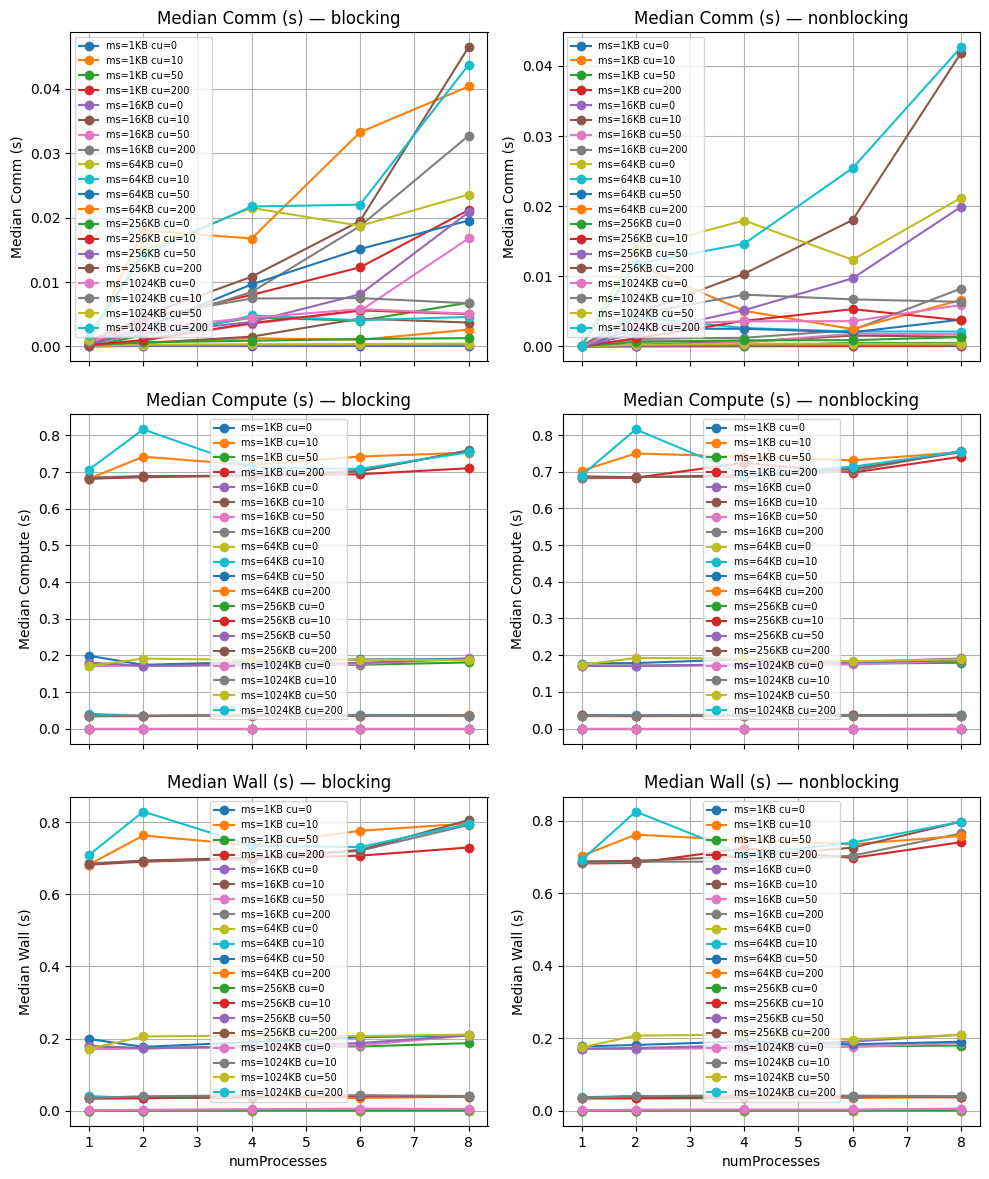

In [30]:
modes = ["blocking","nonblocking"]
metrics = ["medianComm","medianCompute","medianWall"]
metricLabels = {"medianComm":"Median Comm (s)", "medianCompute":"Median Compute (s)", "medianWall":"Median Wall (s)"}

messageSizes = sorted(grouped["messageSizeBytes"].unique())
fig, axes = plt.subplots(len(metrics), len(modes), figsize=(5 * len(modes), 4 * len(metrics)), sharex=True)
if len(modes) == 1:
    axes2d = np.array([[axes[i]] for i in range(len(metrics))])
else:
    axes2d = axes

for colIdx, modeVal in enumerate(modes):
    for rowIdx, metric in enumerate(metrics):
        ax = axes2d[rowIdx][colIdx]
        for ms in messageSizes:
            sub = grouped[(grouped["mode"]==modeVal) & (grouped["messageSizeBytes"]==ms)]
            if sub.empty: continue
            for cu in sorted(sub["computeUnits"].unique()):
                subLine = sub[sub["computeUnits"]==cu].sort_values("numProcesses")
                if subLine.empty: continue
                x = subLine["numProcesses"].values
                y = subLine[metric].values
                label = f"ms={ms//1024}KB cu={cu}"
                ax.plot(x, y, marker='o', linestyle='-', label=label)
        ax.set_title(f"{metricLabels[metric]} — {modeVal}")
        ax.set_ylabel(metricLabels[metric])
        ax.grid(True)
        if rowIdx == len(metrics)-1:
            ax.set_xlabel("numProcesses")
        ax.legend(fontsize=7)
plt.tight_layout()
plt.show()


In [31]:
display(nb.sort_values(["messageSizeBytes","numProcesses"]).head(30))


,mode,messageSizeBytes,numProcesses,computeUnits,medianWall,medianComm,medianCompute,count,stdWall,perUnitCompute,unitsNeeded
300,nonblocking,1024,1,0,0.000018,0.000005,0.000001,3,0.000004,0.003425,1
301,nonblocking,1024,1,10,0.034242,0.000005,0.034202,3,0.000386,0.003425,1
302,nonblocking,1024,1,50,0.170515,0.000010,0.170484,3,0.000316,0.003425,1
303,nonblocking,1024,1,200,0.682355,0.000029,0.682287,3,0.000946,0.003425,1
304,nonblocking,1024,2,0,0.000048,0.000018,0.000001,3,0.000004,0.003428,1
305,nonblocking,1024,2,10,0.034178,0.000028,0.034118,3,0.000156,0.003428,1
306,nonblocking,1024,2,50,0.171643,0.000029,0.171563,3,0.002799,0.003428,1
307,nonblocking,1024,2,200,0.683792,0.000057,0.683677,3,0.003162,0.003428,1
308,nonblocking,1024,4,0,0.000064,0.000027,0.000001,3,0.000042,0.003578,1
309,nonblocking,1024,4,10,0.034402,0.000135,0.034269,3,0.001429,0.003578,1
